In [1]:
import numpy as np
import collections
import matplotlib.pyplot as plt
import os
import sys
sys.path.append('../')
from utils import load_results
from utils import precision_recall_scores as roc
from utils import mpl_stylesheet
from utils import utils
# mpl_stylesheet.banskt_presentation(fontfamily = 'system')

def get_dict_for_method(method, input_dir, chrms, tissue, sb = '0.01'):
    chrmdicts = [dict() for c in chrms]
    datadir = os.path.join(input_dir, tissue)
    print("Reading {:s} for {:s}".format(tissue, method))
    for i, chrm in enumerate(chrms):
        if method == 'tejaas_maf':
            sb = '0.001'
            filepath = os.path.join(datadir, 'tejaas', 'mafnull_sb{:s}'.format(sb), 'chr{:d}'.format(chrm), 'rr.txt')
            chrmdicts[i] = load_results.tejaas(filepath)
        elif method == 'tejaas_rand_maf':
            sb = '0.001'
            filepath = os.path.join(datadir, 'tejaas_rand', 'mafnull_sb{:s}'.format(sb), 'chr{:d}'.format(chrm), 'rr.txt')
            chrmdicts[i] = load_results.tejaas(filepath)
        elif method == 'tejaas_perm':
            filepath = os.path.join(datadir, 'tejaas', 'permnull_sb{:s}'.format(sb), 'chr{:d}'.format(chrm), 'rr.txt')
            print("Loading ", filepath)
            chrmdicts[i] = load_results.tejaas(filepath)
        elif method == 'tejaas_perm_sp':
            filepath = os.path.join(datadir, 'tejaas', 'permnull_sb{:s}'.format(sb), 'chr{:d}'.format(chrm), 'rr_it1.txt')
            print("Loading ", filepath)
            chrmdicts[i] = load_results.tejaas(filepath)
        elif method == 'tejaas_rand_perm':
            filepath = os.path.join(datadir, 'tejaas_rand', 'permnull_sb{:s}'.format(sb), 'chr{:d}'.format(chrm), 'rr.txt')
            print("Loading ", filepath)
            chrmdicts[i] = load_results.tejaas(filepath)
        elif method == 'tejaas_rand_perm_sp':
            filepath = os.path.join(datadir, 'tejaas_rand', 'permnull_sb{:s}'.format(sb), 'chr{:d}'.format(chrm), 'rr_it1.txt')
            print("Loading ", filepath)
            chrmdicts[i] = load_results.tejaas(filepath)
        elif method == 'cpma':
            filepath = os.path.join(datadir, 'tejaas', 'jpa', 'chr{:d}'.format(chrm), 'jpa.txt')
            chrmdicts[i] = load_results.jpa(filepath)
        elif method == 'cpma_rand':
            filepath = os.path.join(datadir, 'tejaas_rand', 'jpa', 'chr{:d}'.format(chrm), 'jpa.txt')
            chrmdicts[i] = load_results.jpa(filepath)
        elif method == 'matrixeqtl':
            filepath = os.path.join(datadir, 'matrixeqtl', 'chr{:d}'.format(chrm), 'trans_eqtl.txt')
            chrmdicts[i] = load_results.matrixeqtl(filepath)
        elif method == 'matrixeqtl_fdr':
            filepath = os.path.join(datadir, 'matrixeqtl', 'chr{:d}'.format(chrm), 'trans_eqtl.txt')
            chrmdicts[i] = load_results.matrixeqtl_fdr(filepath)
        elif method == 'matrixeqtl_rand':
            filepath = os.path.join(datadir, 'matrixeqtl_rand', 'chr{:d}'.format(chrm), 'trans_eqtl.txt')
            chrmdicts[i] = load_results.matrixeqtl(filepath)

    res = dict()
    for d in chrmdicts:
        for k, v in d.items():
            res[k] = v
    return res

def update_sparse_dict(old_dict, new_dict):
    for key in new_dict.keys():
        if old_dict.get(key, False):
            old_dict[key] = new_dict[key]
        else:
            print("SNP {:s} not present".format(key))
    return old_dict

def get_dict_for_no_crxn(method, input_dir, chrms, tissue, sb = '0.01'):
    chrmdicts = [dict() for c in chrms]
    datadir = os.path.join(input_dir, tissue)
    print("Reading {:s} for {:s}".format(tissue, method))
    for i, chrm in enumerate(chrms):
        if method == 'matrixeqtl':
            filepath = os.path.join(datadir, 'gtex_MatrixEQTL_chr{:d}.transout'.format(chrm))
            chrmdicts[i] = load_results.matrixeqtl(filepath)
        elif method == 'matrixeqtl_fdr':
            filepath = os.path.join(datadir, 'gtex_MatrixEQTL_chr{:d}.transout'.format(chrm))
            chrmdicts[i] = load_results.matrixeqtl_fdr(filepath)

    res = dict()
    for d in chrmdicts:
        for k, v in d.items():
            res[k] = v
    return res

INFO_FIELDS = ['rsid', 'stat', 'causality']
class ValidateResult(collections.namedtuple('_ValidateResult', INFO_FIELDS)):
    __slots__ = ()


def validate(testdict, valdict, smax = -np.log10(0.05), nmax = None, empirical = False):
    if empirical:
        if nmax is None:
            totsnps = len(list(testdict.keys()))
            nmax = int(np.round(totsnps/20))
            print("totsnps:", totsnps, " nmax:", nmax)
        sorted_snps = [x[0] for x in sorted(valdict.items(), key=lambda x: x[1], reverse = True)]
        topsnps = sorted_snps[:nmax]
    else:
        topsnps = [k for k,v in valdict.items() if v > smax]
    data = dict()
    for key, value in testdict.items():
        data[key] = ValidateResult(rsid = key, stat = value, causality = 0)
    for key in topsnps:
        if key in data:
            data[key] = ValidateResult(rsid = key, stat = data[key].stat, causality = 1)
    datalist = list()
    for key, value in data.items():
        datalist.append(value)
    return datalist

In [9]:
import itertools 

# chrms = [6, 7, 8, 22]
chrms = [22] #,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22]
# datasets = ['gtex-hlv', 'gtex-ms']
datasets = ['gtex-wb', 'gtex-sse', 'gtex-thy', 'gtex-bca', 'gtex-bce', 'gtex-aa']
# datasets = ["gtex-ban", "gtex-bceh", "gtex-bco", "gtex-bfr", "gtex-bhi", "gtex-bhy", \
# "gtex-bnu", "gtex-bpu", "gtex-bca", "gtex-bce", "gtex-as", \
# "gtex-av", "gtex-ag", "gtex-ac", "gtex-at", "gtex-br", "gtex-ebv", \
# "gtex-fib", "gtex-cols", "gtex-colt", "gtex-esog", "gtex-esom", "gtex-esomu", \
# "gtex-haa", "gtex-liv", "gtex-lu", "gtex-ov", "gtex-pan", "gtex-pit", "gtex-pro", \
# "gtex-snse", "gtex-si", "gtex-spl", "gtex-sto", "gtex-ut", "gtex-va", \
# "gtex-aa", "gtex-hlv", "gtex-ms", "gtex-sse", "gtex-tes", "gtex-thy", "gtex-wb"]

# methods = ['tejaas_maf', 'tejaas_perm', 'cpma', 'matrixeqtl', 'matrixeqtl_fdr',
#            'tejaas_rand_maf', 'tejaas_rand_perm', 'cpma_rand', 'matrixeqtl_rand']
methods = ['tejaas_perm', 'tejaas_rand_perm', 'matrixeqtl', 'matrixeqtl_fdr', 'matrixeqtl_rand', "cpma"]
input_dir = '/cbscratch/franco/trans-eqtl/dev-pipeline/lmcorrected'
#input_dir = '/scratch/sbanerj/trans-eqtl/dev-pipeline/uncorrected'

combi = [x for x in itertools.combinations(datasets,2)]

In [ ]:
# Load all datasets first
data = collections.defaultdict(dict)
for dataset in datasets:
    for key in methods:
        if input_dir.endswith('uncorrected'):
            data[dataset][key] = get_dict_for_no_crxn(key, input_dir, chrms, dataset)
        else:
            data[dataset][key] = get_dict_for_method(key, input_dir, chrms, dataset)
        if key.endswith("_sp"):
            print("going with ", dataset, key)
            data[dataset][key] = update_sparse_dict(data[dataset][key.rstrip("_sp")].copy(), data[dataset][key])

In [ ]:
res = collections.defaultdict(dict)
tissue_pairs = []
for combination in combi:
    tissue_pair = combination[0]+"_"+combination[1]
    tissue_pairs.append(tissue_pair)
    for key in methods:
        print(key, tissue_pair)    
        res[tissue_pair][key] = collections.defaultdict(dict)
        res[tissue_pair][key]['test']     = data[combination[0]][key]
        res[tissue_pair][key]['crossval'] = data[combination[1]][key]

In [ ]:
valres = collections.defaultdict(dict)
for tissue_pair in tissue_pairs:
    for key in methods:
        valres[tissue_pair][key] = collections.defaultdict(dict)
        print("Validating {:s} {:s}".format(key, tissue_pair))
        testdict, valdict = utils.get_compatible_snp_dicts(res[tissue_pair][key]['test'], res[tissue_pair][key]['crossval'])
        valres[tissue_pair][key] = validate(testdict, valdict, empirical=True)

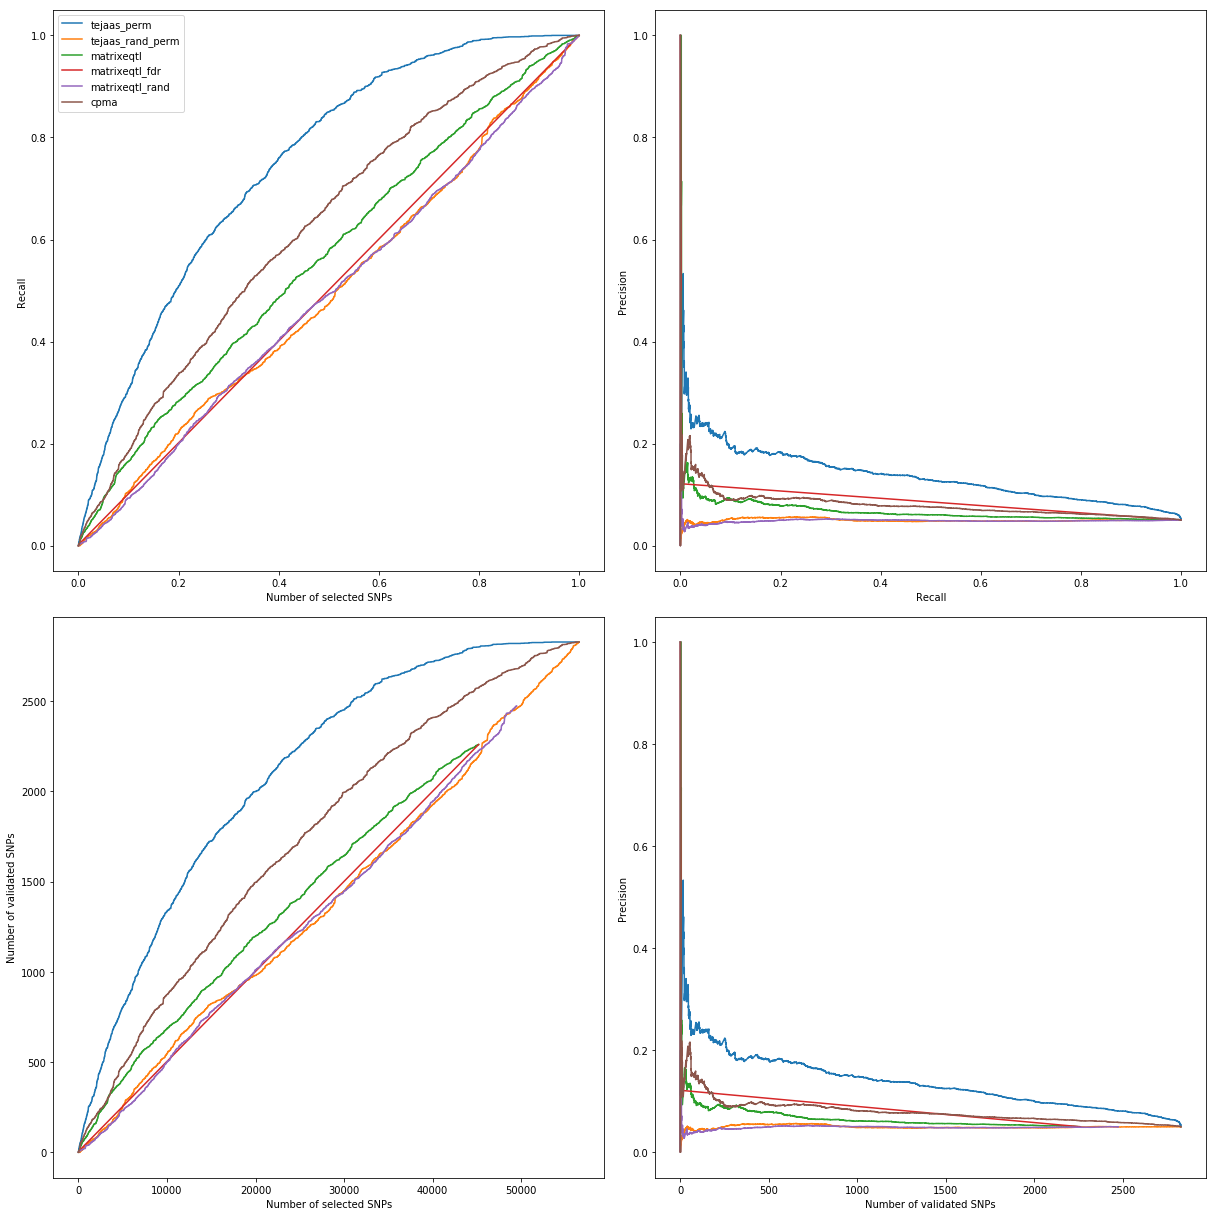

In [13]:
#outfile = 'gtex_ms_hlv_lmcorrected_validation_tejaas-sb0_01_chr-7-8.pdf'
#outfile = 'validation_methods_comparison_matrixeqtl_ms_hlv_no_correction.png'
outfile = "../plots/gtex_hlv_ms_lmcorrected_validation_chr22_sp.png"

fig = plt.figure(figsize = (17, 17))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)

plot_methods = ['tejaas_maf', 'tejaas_perm', 'cpma', 'matrixeqtl', 'matrixeqtl_fdr',
                'tejaas_rand_maf', 'tejaas_rand_perm', 'cpma_rand', 'matrixeqtl_rand']
plot_methods = ['tejaas_perm', 'tejaas_rand_perm', 'matrixeqtl', 'matrixeqtl_fdr', 'matrixeqtl_rand', 'cpma']

tissue_pair = 'gtex-bca_gtex-bce'
for key in plot_methods:
    nsel, tpr, ppv, valids = roc.confusion_matrix(valres[tissue_pair][key])
    scaled_nsel = nsel / max(nsel)
    ax1.plot(scaled_nsel, tpr, label = key)
    ax2.plot(tpr, ppv, label = key)
    ax3.plot(nsel, valids, label = key)
    ax4.plot(valids, ppv, label = key)

    
mlabel = r'Number of selected SNPs'
ax1.set_xlabel(mlabel)
ax3.set_xlabel(mlabel)
mlabel = r'Recall'
ax1.set_ylabel(mlabel)
ax2.set_xlabel(mlabel)
mlabel = r'Number of validated SNPs'
ax4.set_xlabel(mlabel)
ax3.set_ylabel(mlabel)
mlabel = r'Precision'
ax2.set_ylabel(mlabel)
ax4.set_ylabel(mlabel)

#ax2.set_xlim([0, 1000])
#ax1.set_xlim([0, 10000])
#ax1.set_ylim([0, 5000])
ax1.legend()
plt.tight_layout()
# plt.savefig(outfile, bbox_inches='tight')
plt.show()

tejaas_perm
tejaas_rand_perm
matrixeqtl
matrixeqtl_fdr
cpma


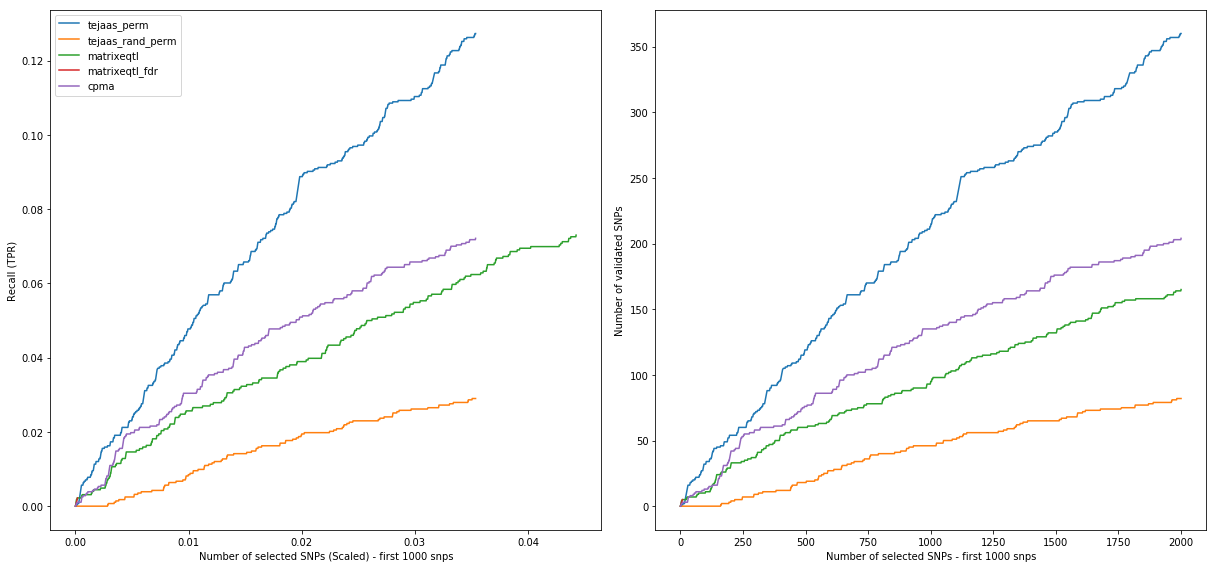

In [14]:
#outfile = 'gtex_ms_hlv_lmcorrected_validation_tejaas-sb0_01_chr-7-8.pdf'
#outfile = 'validation_methods_comparison_matrixeqtl_ms_hlv_no_correction.png'

fig = plt.figure(figsize = (17, 8))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

tissue_pair = 'gtex-bca_gtex-bce'
plot_methods = [ 'tejaas_perm', 'tejaas_rand_perm', 'matrixeqtl', 'matrixeqtl_fdr', 'cpma']
for key in plot_methods:
    nsel, tpr, ppv, valids = roc.confusion_matrix(valres[tissue_pair][key])
    scaled_nsel = nsel / max(nsel)
    #ax1.plot(scaled_nsel, tpr, label = key)
    #ax2.plot(tpr, ppv, label = key)
    Nmax = min(2000, len(nsel)-1)
    ix = nsel < Nmax
    x = np.append(nsel[ ix ], Nmax)
    xscaled  = np.append(scaled_nsel[ ix ], Nmax/max(nsel))
    
    y = np.append(valids[ ix ], valids[ np.sum(ix)])
    ytpr = np.append(tpr[ ix ],    tpr[ np.sum(ix)])
    print(key)
    ax1.plot(xscaled, ytpr, label = key)
    ax2.plot(x, y, label = key)
    
mlabel = r'Number of selected SNPs (Scaled) - first 1000 snps'
ax1.set_xlabel(mlabel)
mlabel = r'Number of selected SNPs - first 1000 snps'
ax2.set_xlabel(mlabel)
mlabel = r'Recall (TPR)'
ax1.set_ylabel(mlabel)
mlabel = r'Number of validated SNPs'
ax2.set_ylabel(mlabel)

# ax1.set_xlim([0, 100])
# ax1.set_ylim([0, 60])
ax1.legend()
plt.tight_layout()
#plt.savefig(outfile, bbox_inches='tight')
plt.show()

In [15]:
from sklearn import metrics

aucs   = dict()
aucs1k = dict()

method_dict = collections.defaultdict(lambda: np.zeros((len(datasets),len(datasets))))
matrix_dict = dict(zip(datasets, np.arange(len(datasets))))

plot_methods = ['tejaas_perm', 'tejaas_rand_perm'] #, 'tejaas_perm_sp', 'tejaas_rand_perm_sp']
plot_methods = ['tejaas_perm', 'tejaas_rand_perm', 'matrixeqtl', 'matrixeqtl_fdr', 'cpma']

for key in plot_methods:
    auc_array = np.zeros((len(datasets),len(datasets)))
    for tissue_pair in tissue_pairs:
        i = matrix_dict[tissue_pair.split("_")[0]]
        j = matrix_dict[tissue_pair.split("_")[1]]
        nsel, tpr, ppv, valids = roc.confusion_matrix(valres[tissue_pair][key])
        scaled_nsel = nsel / max(nsel)
        auc = metrics.auc(scaled_nsel, tpr)
        ix = nsel < 1000
        xscaled  = np.append(scaled_nsel[ ix ], 1000/max(nsel))
        ytpr = np.append(tpr[ ix ], tpr[ np.sum(ix)])
        auc1k = metrics.auc(xscaled, ytpr)
        auc_array[j,i] = auc
        aucs[key] = auc
        aucs1k[key] = auc1k
        print(tissue_pair, key, auc, auc1k)
    method_dict[key] = auc_array

gtex-wb_gtex-sse tejaas_perm 0.7746517538073867 0.0007492423319081846
gtex-wb_gtex-thy tejaas_perm 0.7733675710778347 0.0006082554513822462
gtex-wb_gtex-bca tejaas_perm 0.6528492530943705 0.0003437616248911968
gtex-wb_gtex-bce tejaas_perm 0.6500220651737 0.00028726995299357657
gtex-wb_gtex-aa tejaas_perm 0.733094864839806 0.00032228297162114033
gtex-sse_gtex-thy tejaas_perm 0.7636467609302959 0.0006806200668973448
gtex-sse_gtex-bca tejaas_perm 0.6802969179014214 0.000332590849325853
gtex-sse_gtex-bce tejaas_perm 0.6637327180629808 0.00032700389832241903
gtex-sse_gtex-aa tejaas_perm 0.7259506614512287 0.00040708144507728904
gtex-thy_gtex-bca tejaas_perm 0.6547955786214128 0.0003121439217587249
gtex-thy_gtex-bce tejaas_perm 0.6624810784632524 0.0003455311907937953
gtex-thy_gtex-aa tejaas_perm 0.7303377779909872 0.0004404687141123594
gtex-bca_gtex-bce tejaas_perm 0.7479252152436184 0.0007258690550745686
gtex-bca_gtex-aa tejaas_perm 0.5987532451525087 0.0002092433518784674
gtex-bce_gtex-aa

In [327]:
method_dict.keys()

dict_keys(['tejaas_perm', 'tejaas_perm_sp', 'tejaas_rand_perm', 'tejaas_rand_perm_sp', 'matrixeqtl', 'matrixeqtl_fdr'])

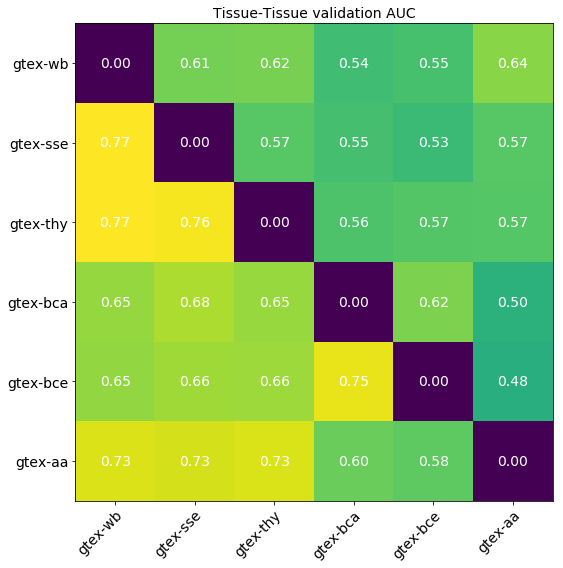

In [16]:
N = len(datasets)

key1 = "tejaas_perm"
key2 = "cpma"
method_array = method_dict[key1] + method_dict[key2].T

fig = plt.figure(figsize = (8, 8))
ax = fig.add_subplot(111)
im = ax.imshow(method_array)
ax.set_xticks(np.arange(N))
ax.set_yticks(np.arange(N))
ax.set_xticklabels(datasets, fontsize=14)
ax.set_yticklabels(datasets, fontsize=14)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")
for i in range(N):
    for j in range(N):
        text = ax.text(j, i, "{:.2f}".format(method_array[i, j]),
                       ha="center", va="center", color="w", fontsize=14)

ax.set_title("Tissue-Tissue validation AUC", fontsize=14)
fig.tight_layout()
plt.show()